# Generative Adversarial Network for Augmentation of Laser-Based Laryngeal Imaging

For the deep-learning-based algorithm to match features via a registration task, it is essential to apply intense data augmentation to the training data set. As displayed in the following figure the training data consists of images $m(x)$ that represent the spatial configuration of laser points projected onto the vocal fold surface.

![alt text here](images/feature_matching_registration.png "Logo Title Jupyter Notebook logo")

The foundation for the images $m(x)$ are the x-y-coordinates of each single laser point within the image, as $m(x)$ is generated by plotting the single laser points and then smoothing the image. To create intense augmentation we want to train a generative adversaraial network (GAN) to then generate images that are variations of the images of the training set and represent feasible configurations of laser points projected onto a vocal fold. The implementation of the GAN is inspired by [Keras](https://keras.io/examples/generative/dcgan_overriding_train_step/).

## Import Statements
The notebook was developed on Keras using the Tensorflow 2.2.0 backend.

In [1]:
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import os
from tensorflow.keras.preprocessing import image
from matplotlib import pyplot as plt
import glob
import json

## Hardware Configuration
Check for GPU and allow memory growth such that limitations for training are reduced. 

In [2]:
print(tf.__version__)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.get_visible_devices('GPU')

2.2.0-rc3


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Model parameters
The grid dimensions have to be know, as well as the image dimensions for scaling. The depth of the input and output layer is 2 here, as we will have one channel representing x-coordinates and a second channel representing y-coordinates. 

In [3]:
height = 18
width = 18
channels = 2

image_width = 728
image_height = 728

## Hyperparameters
The dimension of the latent space can be adapted to optimize the network. 

In [4]:
latent_dim = 8
filters = 256

## Generator
The first part of a GAN is a generator network that takes random input vectors from the latent space and decodes the vector to generate a synthetic image.

In [5]:
x_factor = (width+2) // 4
y_factor = (height+2) // 4

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim+1,)),
        # We want to generate 128 coefficients to reshape into a 7x7x128 map
        layers.Dense(x_factor * y_factor * filters),
        layers.LeakyReLU(alpha=0.2),
        layers.Reshape((x_factor, y_factor, filters)),
        layers.Conv2DTranspose(filters, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(filters, (4, 4), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(2, (x_factor, y_factor), padding="same", activation="tanh"),
    ],
    name="generator",
)

generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6400)              64000     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6400)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 256)       1048832   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 10, 10, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 256)       1048832   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 20, 20, 256)       0 

## Discriminator
The second part of the GAN is a discriminator network that takes an image as input and decides if the image comes from the training set or was synthetically created by the generator.

In [6]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(width+2, height+2, 3)),
        layers.Conv2D(filters//2, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(filters, (3, 3), strides=(2, 2), padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(), #layers.GlobalMaxPooling2D(),
        layers.Dropout(0.5),
        layers.Dense(1),
    ],
    name="discriminator",
)

discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 10, 128)       3584      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 256)         295168    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 5, 5, 256)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dropout (Dropout)            (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)               

## GAN
The gan itself is composed by the generator and the discriminator.

In [7]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_labels = tf.round(tf.random.normal(shape=(batch_size, 1)) * 7.0)
        random_latent_vectors = tf.concat([random_latent_vectors, random_labels], axis=1)
        labeled_images = tf.reshape(tf.repeat(random_labels, repeats=20*20), (batch_size, 20, 20, 1))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)
        generated_images = tf.concat([generated_images, labeled_images], axis=3)
        
        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
        random_labels = tf.round(tf.random.normal(shape=(batch_size, 1)) * 7.0)
        random_latent_vectors = tf.concat([random_latent_vectors, random_labels], axis=1)
        labeled_images = tf.reshape(tf.repeat(random_labels, repeats=20*20), (batch_size, 20, 20, 1))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors)
            generated_images = tf.concat([generated_images, labeled_images], axis=3)
            predictions = self.discriminator(generated_images)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        return {"d_loss": d_loss, "g_loss": g_loss}

### Prepare data
Load the data and scale them to be between 0.0 an 1.0. Further use zero-padding to get a 20x20 shape for this example. Padding is applied to get 20x20 images, which is divisable twice by 2 such that two upconvolutions can de carried out.

In [8]:
x_position = np.load('data/x_pos_LASTEN2.npy')
y_position = np.load('data/y_pos_LASTEN2.npy')

offset = 0.0

# Non existing points mapping
x_position = np.where(x_position<=0, -offset, x_position) + offset
y_position = np.where(x_position<=0, -offset, y_position) + offset

x_position = x_position / (image_width + offset)
y_position = y_position / (image_height + offset)

# Zero padding
x_position = np.pad(x_position,[(0,0),(1,1),(1,1)],constant_values=0)
y_position = np.pad(y_position,[(0,0),(1,1),(1,1)],constant_values=0)

x_position = x_position[:,:,:,np.newaxis]
y_position = y_position[:,:,:,np.newaxis]

label = np.zeros(x_position.shape)
for i in range(len(x_position)):
    label[i] = i
xy_data = np.concatenate((x_position, y_position, label), axis=3)

#xy_data = np.concatenate((x_position, y_position), axis=3)
print("Shape of 'xy_data': {}".format(xy_data.shape))

Shape of 'xy_data': (160, 20, 20, 3)


## GAN Training
The training of the DCGAN (Deep Convolutional Generative Adversarial Network) is a dynamic process, where an equilibrium between capability of the generator to fake images and the capability of the discriminator to recognize faked images should be achieved. See the "train_step" function of gan. The procedure of training is iterative. The following steps are repeated until a sufficient equilibrium is achieved:

1. We randomly draw points from the latent space assuming a Gaussian distribution.
2. The sample points from 1. are used to generate images with the generator.
3. Generated images (fake) are mixed with images from the trainin set (real).
4. Only the discriminator is trained where fake images get the label "fake" and real images have the label "real". In that way the disciminator learns to judge the generator whether is provided image is fake or real.
5. Again draw random points from the latent space.
6. The points from 5. are labeled as "real" images (although they are not) the parameters of the discriminator are fixed and the whole GAN model is trained. In that way the generator learns to fake images.

In [9]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(np.repeat(generated_images[i][:,:,0][:,:,np.newaxis],3,axis=2))
            img.save("gan_2/generated_img_{i}_{epoch}.png".format(i=i, epoch=epoch))

In [10]:
epochs = 30
batch_size = 20

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=keras.losses.BinaryCrossentropy()#from_logits=True),
)

gan.fit(xy_data, batch_size=batch_size, epochs=epochs)#, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]

Epoch 1/30
8/8 [==============================] - 1s 79ms/step - d_loss: 7.3918 - g_loss: 12.9650
Epoch 2/30
8/8 [==============================] - 1s 79ms/step - d_loss: 7.2166 - g_loss: 14.1975
Epoch 3/30
8/8 [==============================] - 1s 78ms/step - d_loss: 7.2688 - g_loss: 14.7522
Epoch 4/30
8/8 [==============================] - 1s 78ms/step - d_loss: 7.2288 - g_loss: 14.4246
Epoch 5/30
8/8 [==============================] - 1s 78ms/step - d_loss: 7.2644 - g_loss: 14.6637
Epoch 6/30
8/8 [==============================] - 1s 79ms/step - d_loss: 7.2368 - g_loss: 14.4983
Epoch 7/30
8/8 [==============================] - 1s 79ms/step - d_loss: 7.2460 - g_loss: 14.0902
Epoch 8/30
8/8 [==============================] - 1s 79ms/step - d_loss: 7.2306 - g_loss: 14.0177
Epoch 9/30
8/8 [==============================] - 1s 79ms/step - d_loss: 7.2373 - g_loss: 14.5196
Epoch 10/30
8/8 [==============================] - 1s 79ms/step - d_loss: 7.2337 - g_loss: 14.1209
Epoch 11/30
8/8 [==

## Visualize results
A randomly drawn latent vector is used to generate a fake image by the generator.

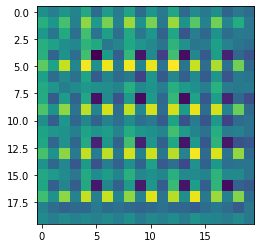

In [28]:
random_latent_vectors = np.random.normal(size=(batch_size, latent_dim)) # sample with mean=0 and std=1.0
random_labels = np.round(np.random.normal(size=(batch_size, 1)) * 7.0)     

random_latent_vectors = np.concatenate((random_latent_vectors, random_labels), axis =1)
    
generated_images = generator.predict(random_latent_vectors)
generated_images *= 255

for i in range(1):
    
    img = generated_images[i,:,:,0]
    img = img[:,:,np.newaxis]
    img = keras.preprocessing.image.array_to_img(img)
    plt.imshow(img)